In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


In [2]:
from SuchTree import SuchTree, SuchLinkedTrees, pearson
from scipy.stats import skew, entropy, gaussian_kde, kurtosis
import pandas as pd
import seaborn
import json
import pyprind

In [3]:
studies = json.load( open( 'data/studies.json' ) )

def load_study( study ) :
    T1  = SuchTree( study['host'] )
    T2  = SuchTree( study['guest'] )
    links = pd.DataFrame.from_csv( study['links'] )
    links = links.loc[ T1.leafs.keys() ]
    links = links[ T2.leafs.keys() ]
    return SuchLinkedTrees( T1, T2, links )

In [4]:
p = pyprind.ProgBar( len(studies), title='building graph Laplacian spectra...' )

bandwidth = 0.2

egs = []
spectra = []
for study in studies :
    SLT = load_study( study )
    eg = SLT.spectrum()
    egs.append(eg)
    spectra.append( gaussian_kde( eg / max(eg), bw_method=bandwidth ).pdf( linspace( -0.5,1.5,200) ) )
    p.update()

building graph Laplacian spectra...
0%                          100%
[##############################] | ETA: 00:00:00
Total time elapsed: 00:00:10


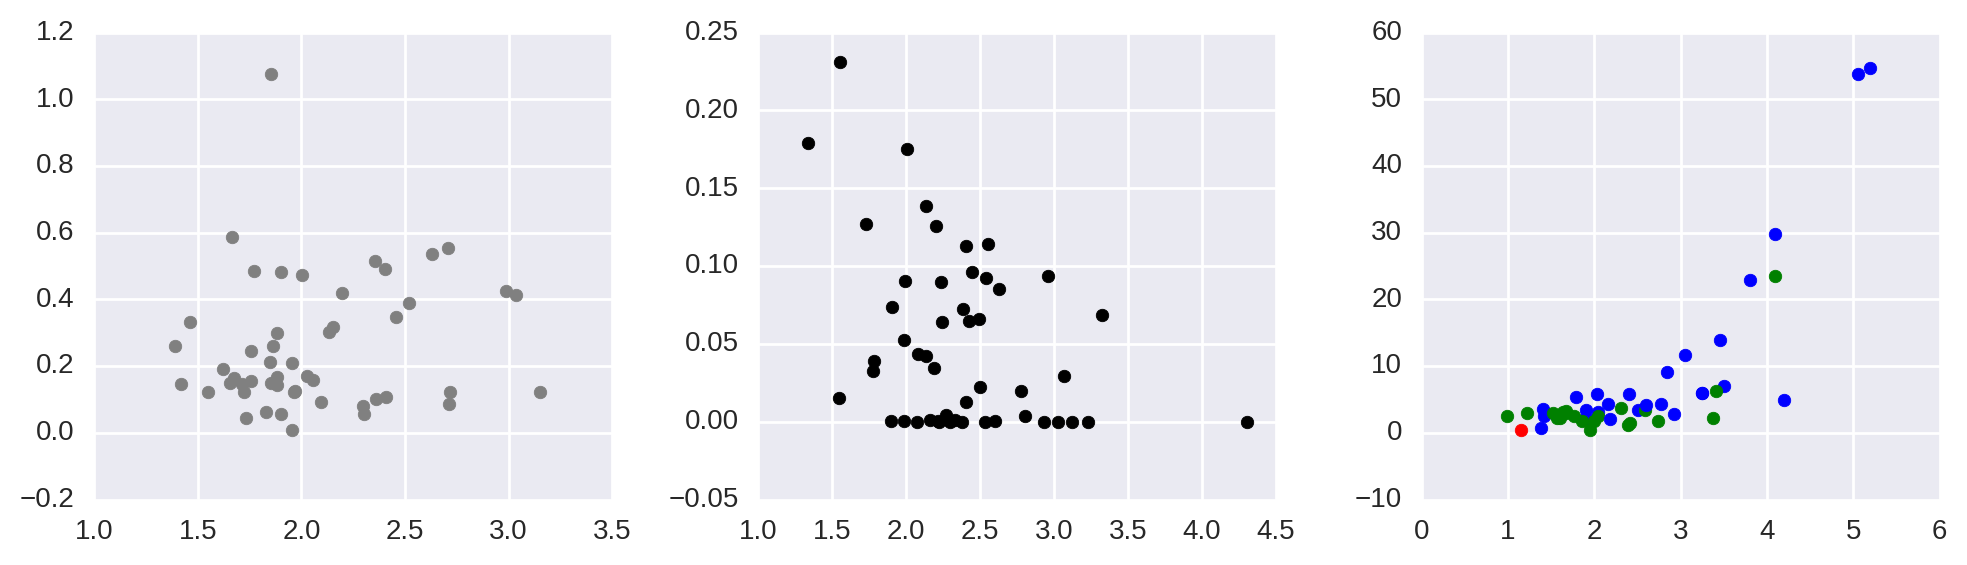

In [5]:
figure(figsize=(10,3))

typecolor = { 'null'        : 'gray', 
              'perfect'     : 'black',
              'parasitism'  : 'red',
              'frugivory'   : 'green',
              'pollination' : 'blue' }

for i,g in enumerate([ ['null'], ['perfect'], ['parasitism', 'frugivory', 'pollination' ] ]) :
    subplot(1,3,i+1)
    for study,eg,s in zip( studies, egs, spectra ) :
        if not study['type'] in g : continue
        #plot( s, color=typecolor[study['type']], lw=0.5 )
        scatter(  skew( s ), eg[-1]-eg[-2], color=typecolor[study['type']]  )
tight_layout()

In [15]:
def pdd( a, b ) :
    return ( 0.5 * entropy( a, b ) + 0.5 * entropy( b, a ) )**(0.5)

distances = zeros( ( len(spectra), len(spectra) ) )

for i,I in enumerate(spectra) :
    for j,J in enumerate(spectra) :
        if i == j : continue
        distances[i,j] = e**pdd( I, J )

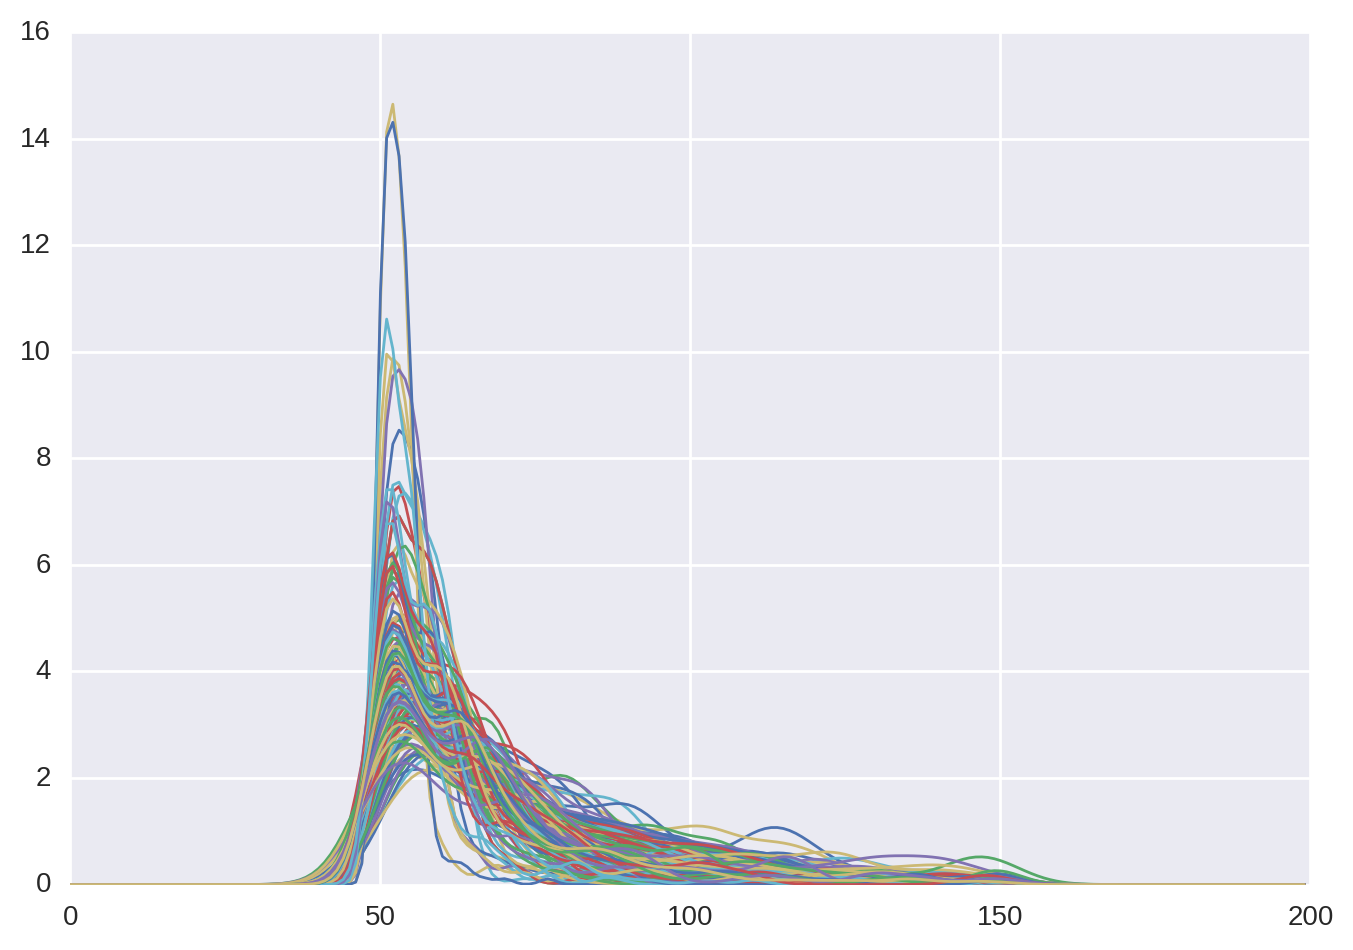

In [8]:
for i,spectrum in enumerate(spectra) :
    plot( spectrum, label=i, lw=1 )

#legend()

In [17]:
pdd( spectra[0], spectra[2] )

1.0512707099046315

/home/russell/opt/lib/python2.7/site-packages/seaborn/matrix.py:143: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if xticklabels == []:
/home/russell/opt/lib/python2.7/site-packages/seaborn/matrix.py:151: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if yticklabels == []:


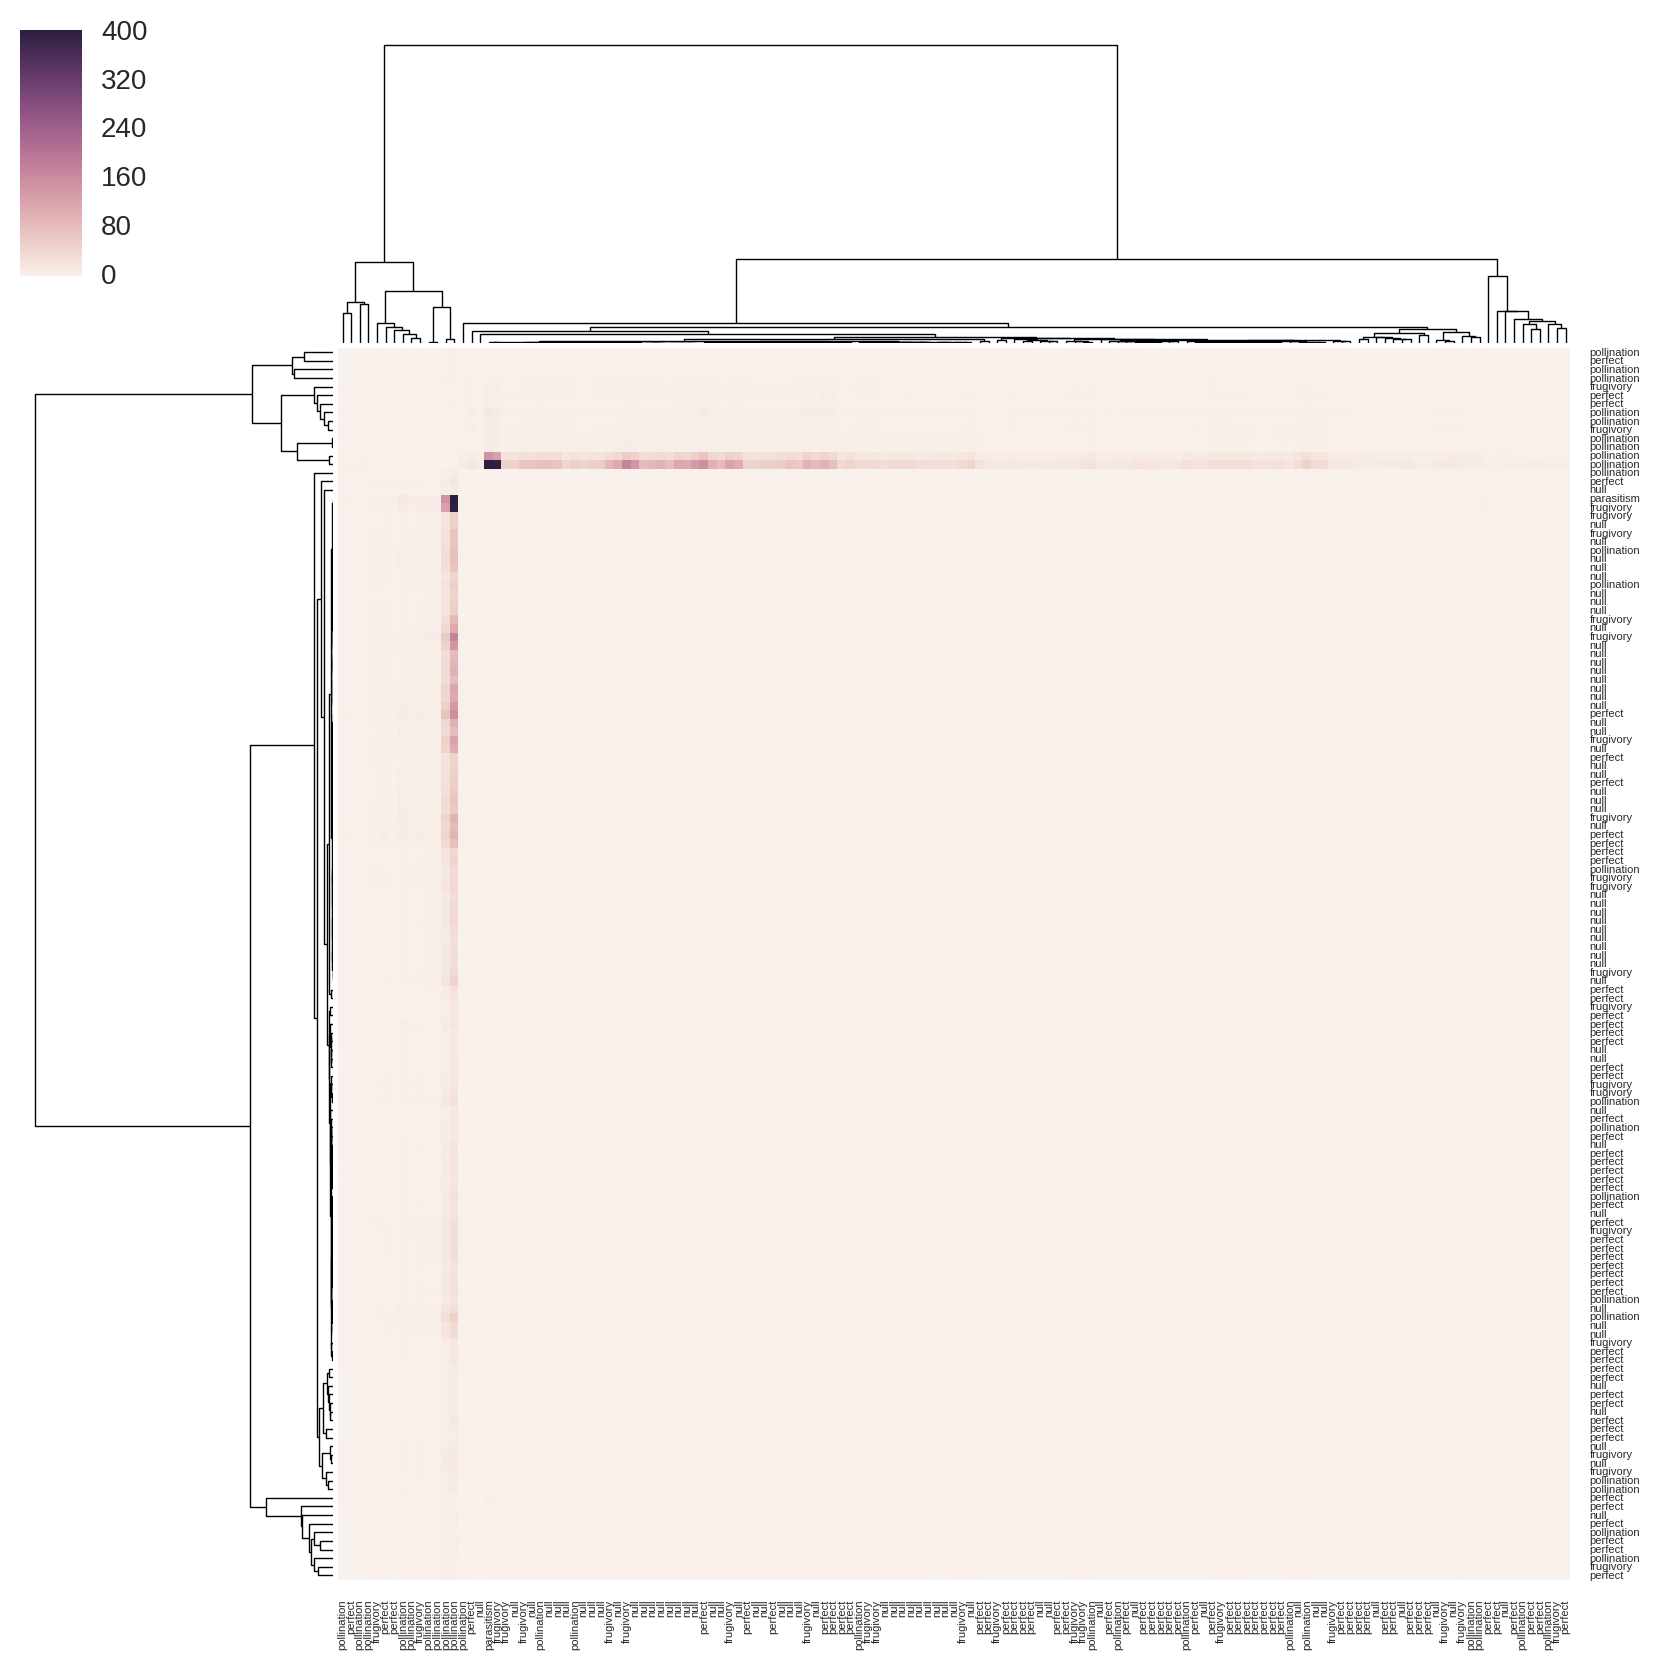

In [18]:
studytypes = map( lambda x : x['type'], studies )
cm = seaborn.clustermap( distances, xticklabels=studytypes, yticklabels=studytypes, metric="correlation" )
ticks = setp(cm.ax_heatmap.yaxis.get_majorticklabels(), rotation=0, fontsize=4 )
ticks = setp(cm.ax_heatmap.xaxis.get_majorticklabels(), fontsize=4 )

In [19]:
N = 100
M = 5
p = pyprind.ProgBar( N*M, title='calculating spectral distances...' )

SLT = load_study( studies[1] )

a = real( eigvals( SLT.laplacian() ) )
A = gaussian_kde( a / max(a), bw_method=0.2 ).pdf( linspace( -0.5,1.5,200) )

s,d = [],[]

for i in xrange( N ) :
    for j in xrange( M ) :
        b = real( eigvals( SLT.laplacian( swaps=i ) ) )
        B = gaussian_kde( b / max(b), bw_method=0.2 ).pdf( linspace( -0.5,1.5,200) )
        s.append( i ) 
        d.append( e**pdd( A, B ) )
        p.update()

calculating spectral distances...
0%                          100%
[##############################] | ETA: 00:00:00
Total time elapsed: 00:00:05


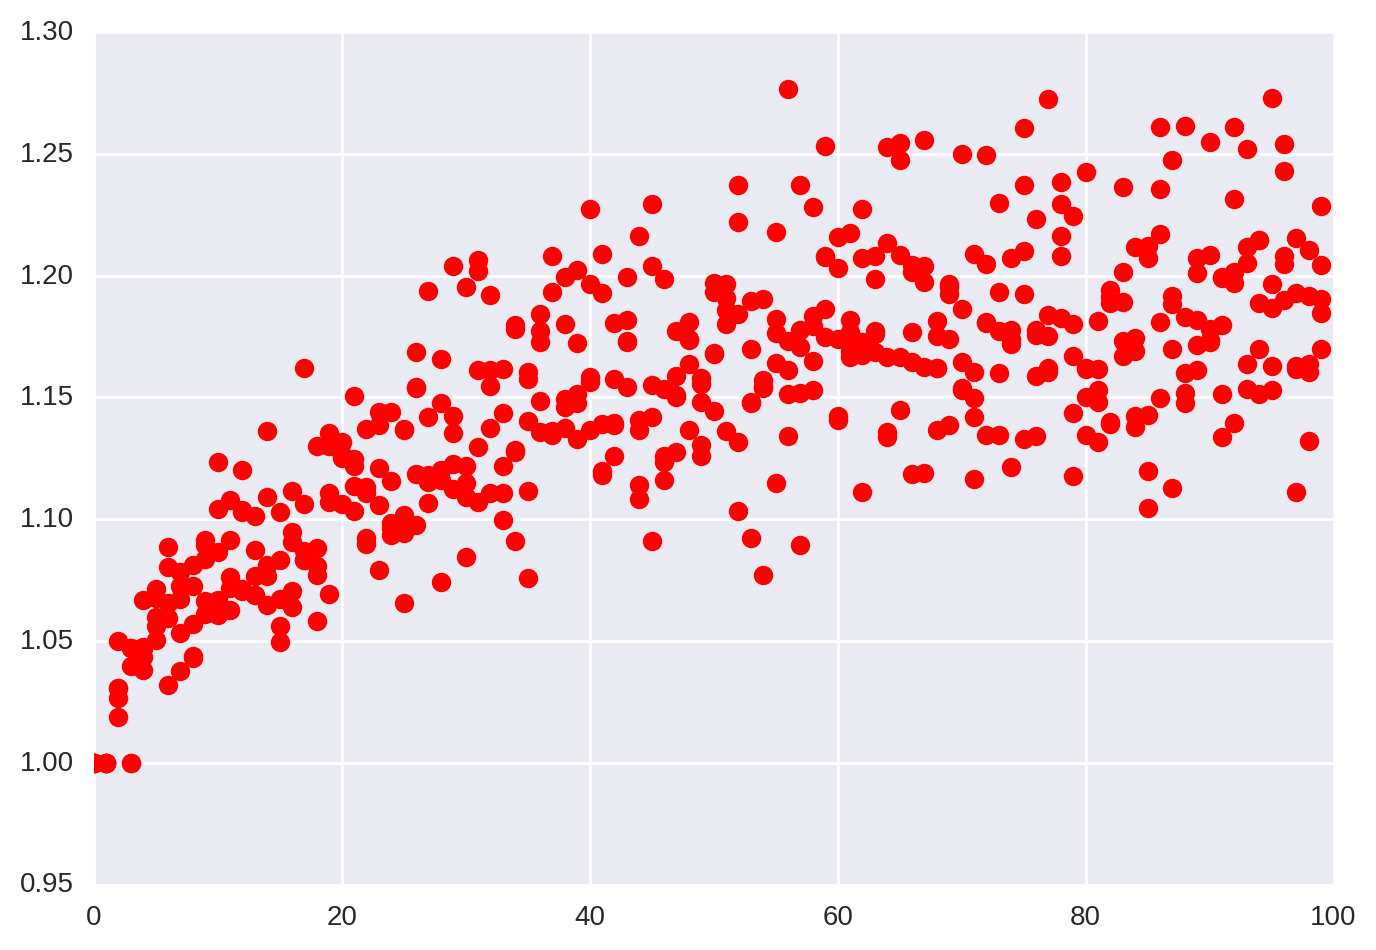

In [20]:
plot(s,d,'ro')

In [49]:
N = 3
M = 100

p = pyprind.ProgBar( N*M, title='calculating spectral distances...' )

SLTa = load_study( studies[0] )
SLTb = load_study( studies[6] )

d = []
s = []

for i in xrange( N ) :
    for j in xrange( M ) :
        a = real( eigvals( SLTa.laplacian( additions=i ) ) )
        A = gaussian_kde( a / max(a), bw_method=0.2 ).pdf( linspace( -0.5,1.5,200) )
        b = real( eigvals( SLTb.laplacian( additions=i ) ) )
        B = gaussian_kde( b / max(b), bw_method=0.2 ).pdf( linspace( -0.5,1.5,200) )
        s.append( i ) 
        d.append( pdd( A, B ) )
        p.update()

calculating spectral distances...
0%                          100%
[##############################] | ETA: 00:00:00
Total time elapsed: 00:00:02


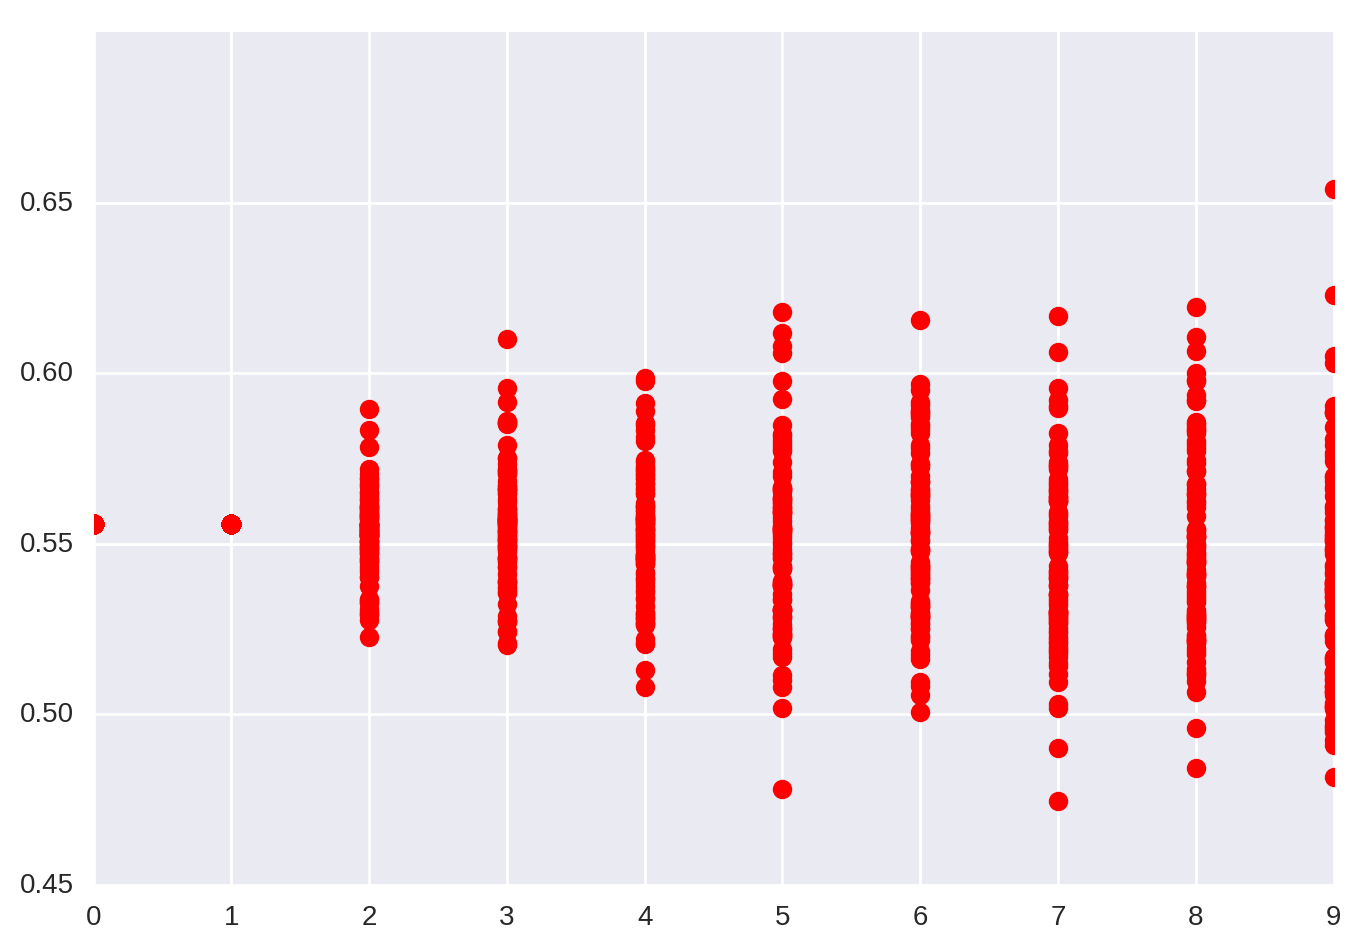

In [32]:
plot(s,d,'ro')

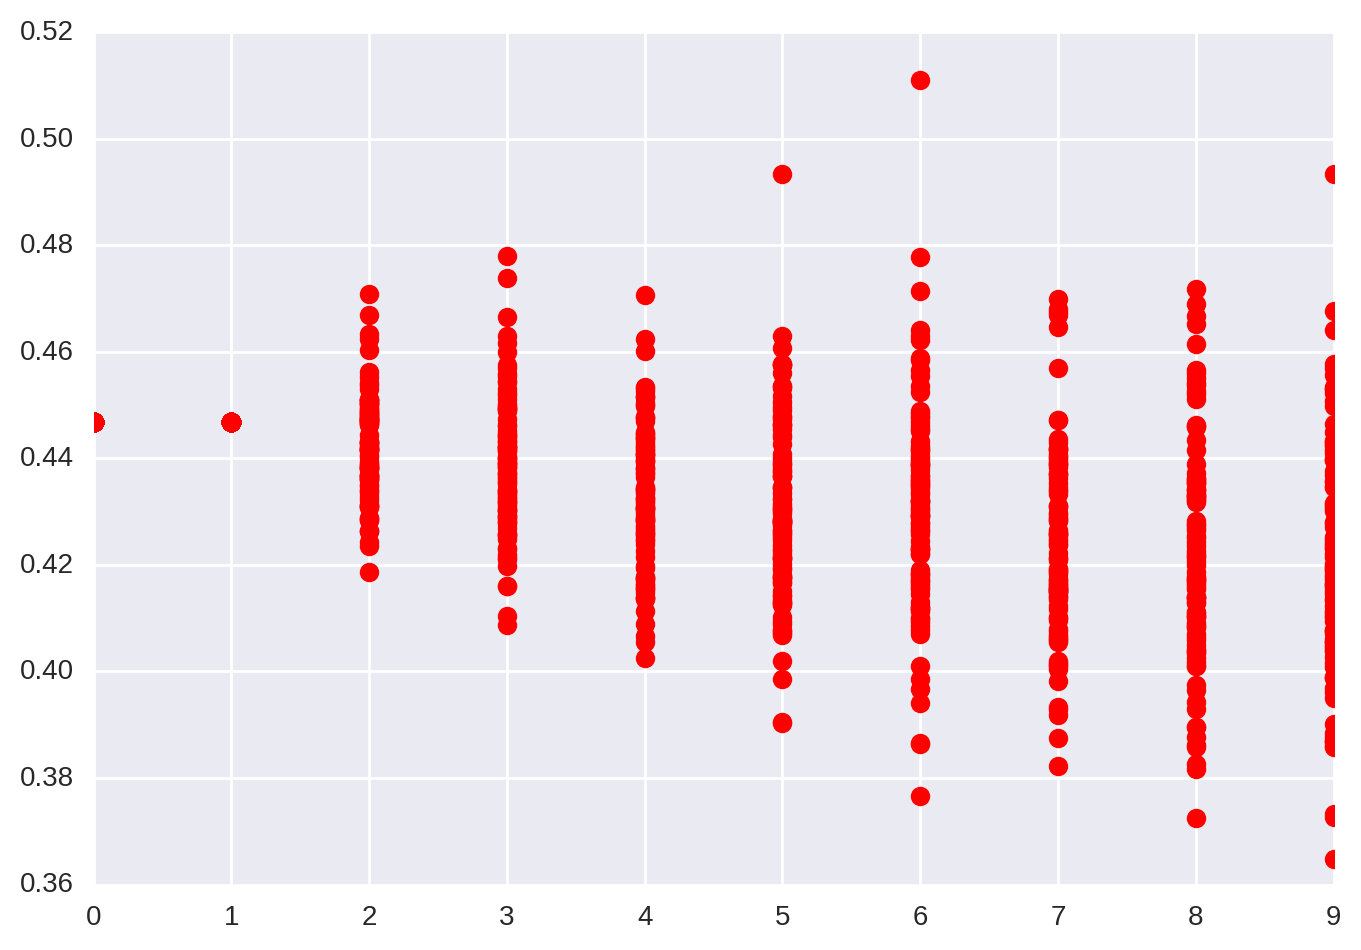

In [30]:
plot(s,d,'ro')

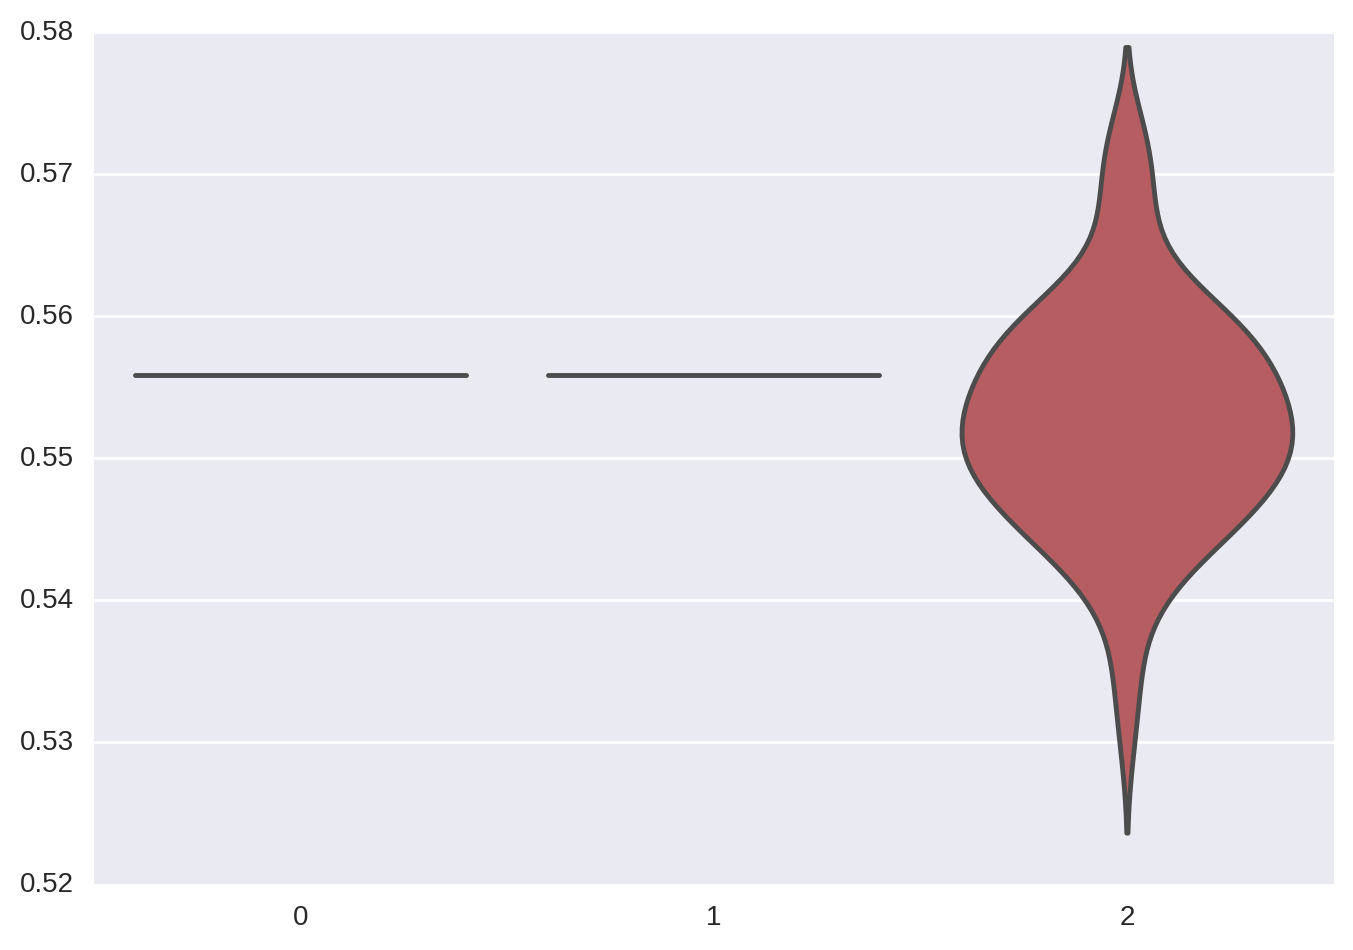

In [50]:
seaborn.violinplot(s,d,inner=None)
#seaborn.stripplot(s,d,jitter=True)

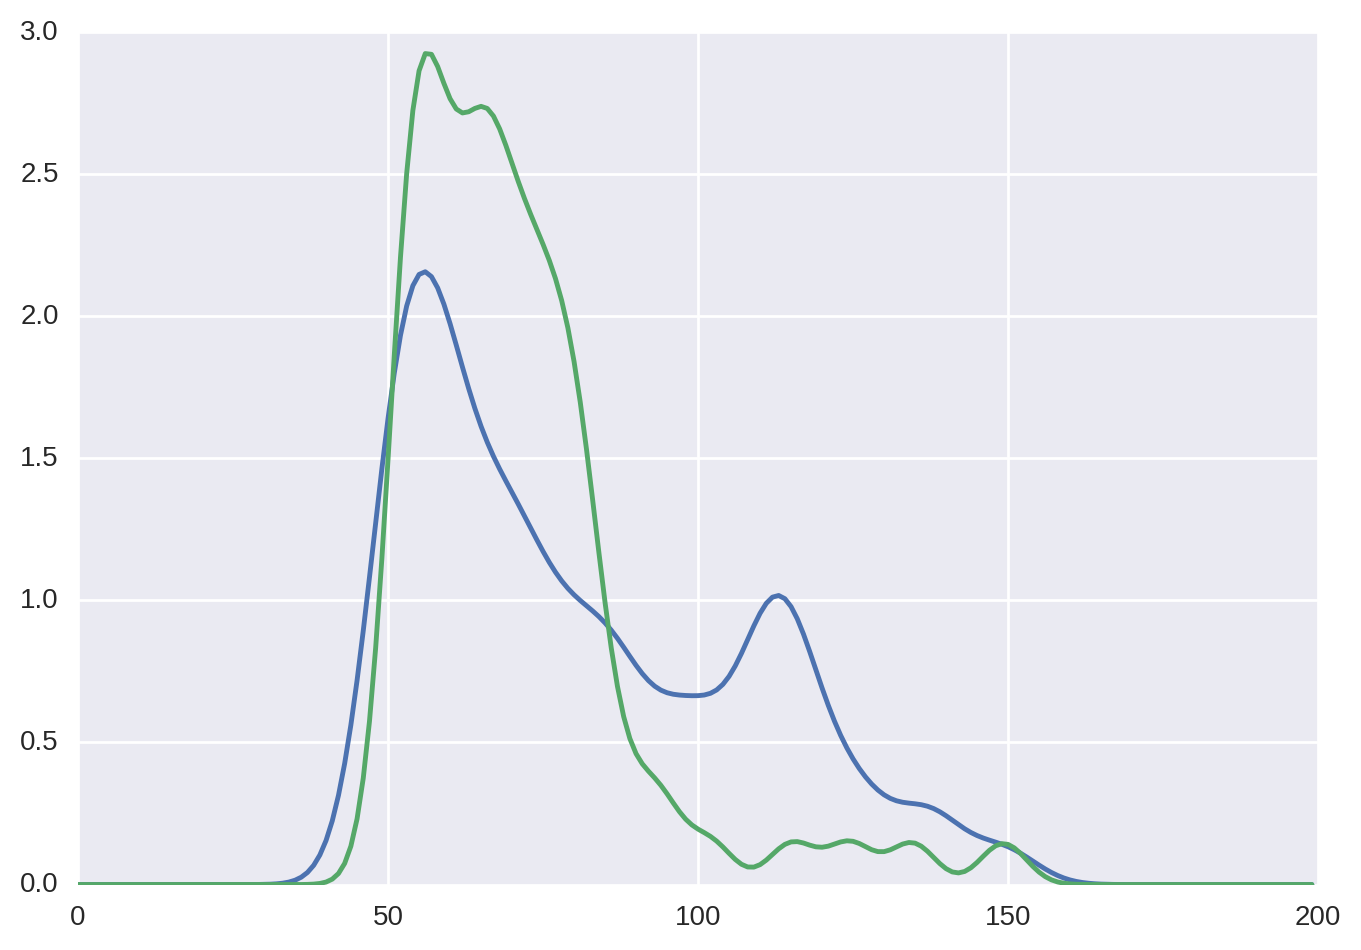

In [54]:
plot(A)
plot(B)

In [20]:
from itertools import combinations

N = 30
permutation_thresh = 0.1

d = []
s = []

names = [ s['name'] for s in studies ]

p = pyprind.ProgBar( len(studies), title='calculating permuted spectra...' )

permutations = []
for study in studies :
    ps = []
    SLT = load_study( study )    
    for i in xrange( N ) :
        M = int( len( SLT.linklist ) * permutation_thresh )
        if M > 1 :
            Mswap = randint(1,M)
            Madd  = randint(1,M)
        else :
            Mswap, Madd = 1,1
        a = SLT.spectrum( swaps=Mswap, additions=Madd )
        A = gaussian_kde( a / max(a), bw_method=0.2 ).pdf( linspace( -0.5,1.5,200) )
        ps.append( A )
    permutations.append( ps )
    p.update()

n = len(studies)
p = pyprind.ProgBar( (n*(n-1))/2, title='calculating permuted distances...' )

distances = zeros( ( len(studies), len(studies) ) )
variances = zeros( ( len(studies), len(studies) ) )

P = []

for (i,perm1),(j,perm2) in combinations( zip(arange(n),permutations), 2 ) :
    d = []
    for spec1 in perm1 :
        for spec2 in perm2 :
            distance = pdd( spec1, spec2 )
            d.append( distance )
            P.append( { 'study1'   : names[i],
                        'study2'   : names[j],
                        'distance' : distance } )
    distances[i,j] = mean( d )
    distances[j,i] = mean( d )
    variances[i,j] = std( d )
    variances[j,i] = std( d )
    p.update()

P = pd.DataFrame( P )
D = pd.DataFrame( distances, columns=names, index=names )
V = pd.DataFrame( variances, columns=names, index=names )

calculating permuted spectra...
0%                          100%
[##############################] | ETA: 00:00:00
Total time elapsed: 00:02:55
calculating permuted distances...
0%                          100%
[##############################] | ETA: 00:00:00
Total time elapsed: 00:06:22


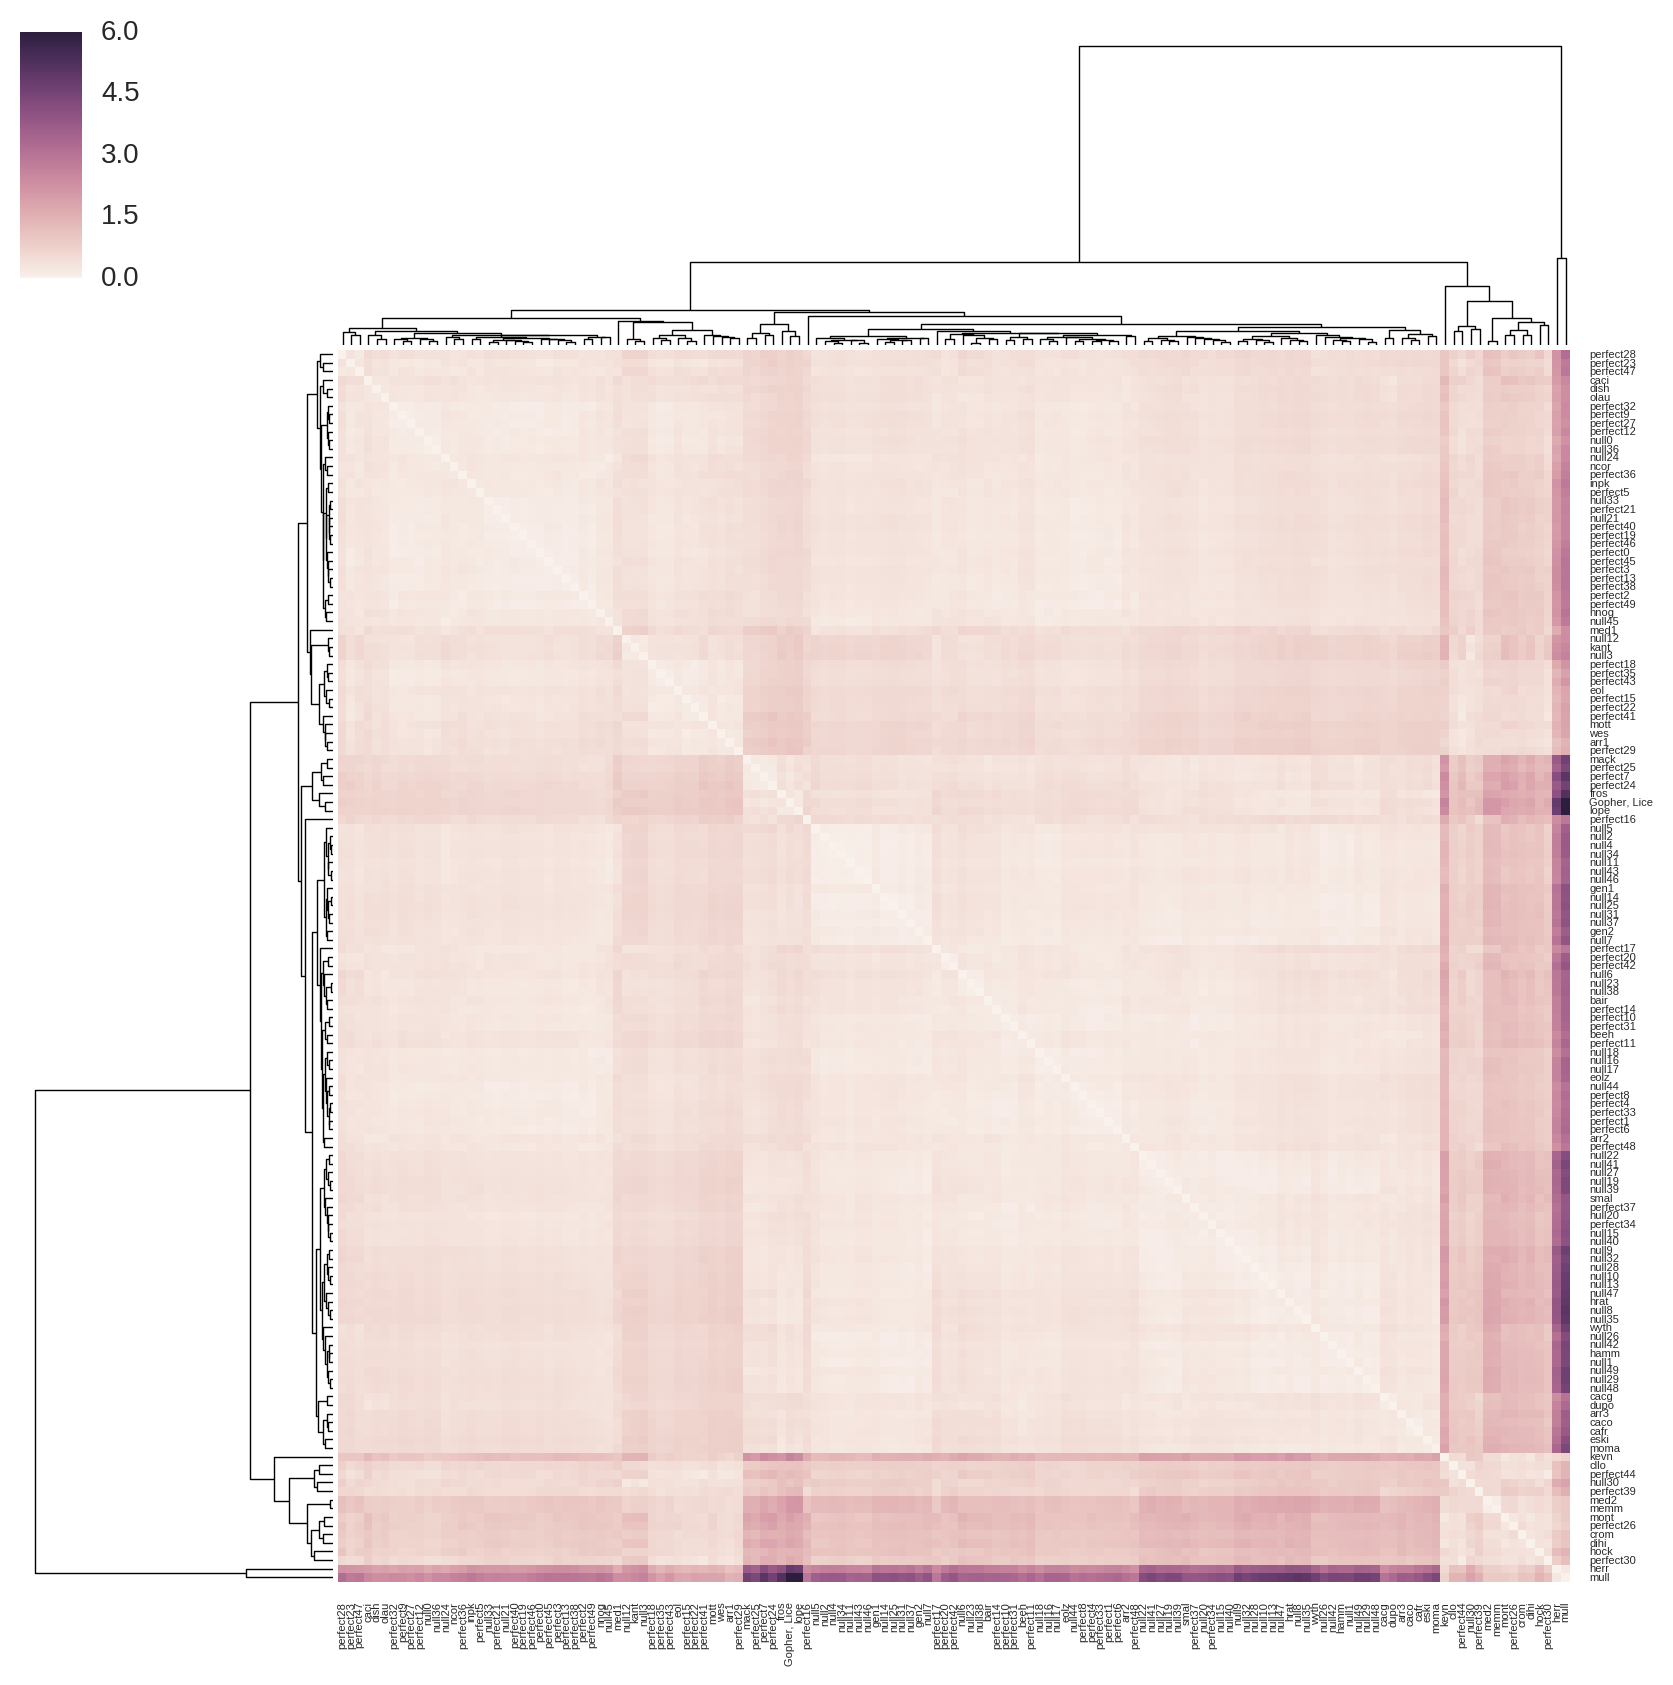

In [21]:
#D = pd.DataFrame.from_csv( 'annealed_distances.csv' )
cm = seaborn.clustermap( D )
ticks = setp(cm.ax_heatmap.yaxis.get_majorticklabels(), rotation=0, fontsize=4 )
ticks = setp(cm.ax_heatmap.xaxis.get_majorticklabels(), fontsize=4 )

/home/russell/opt/lib/python2.7/site-packages/ipykernel/__main__.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()
/home/russell/opt/lib/python2.7/site-packages/seaborn/categorical.py:2342: UserWarning: The violinplot API has been changed. Attempting to adjust your arguments for the new API (which might not work). Please update your code. See the version 0.6 release notes for more info.
  warnings.warn(msg, UserWarning)


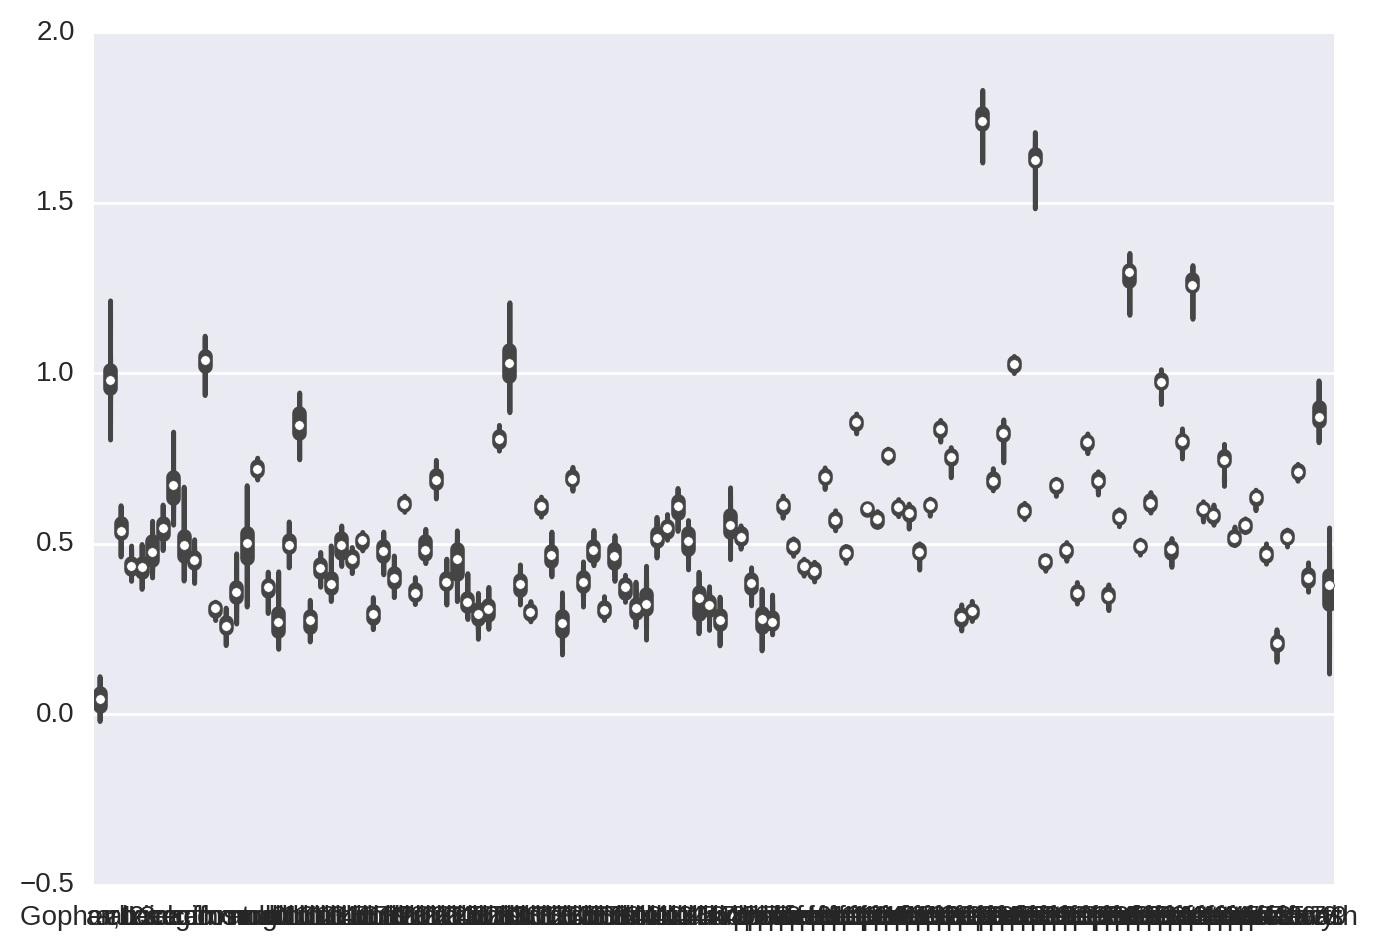

In [86]:
a = {}
for name in names :
    a[name] = P[ P.study1=='Gopher, Lice'][ P.study2==name ]['distance']
a = pd.DataFrame(a)
seaborn.violinplot(a)

In [25]:
P.head

<bound method DataFrame.head of          distance        study1     study2
0        0.496616  Gopher, Lice       beeh
1        0.475904  Gopher, Lice       beeh
2        0.464564  Gopher, Lice       beeh
3        0.531584  Gopher, Lice       beeh
4        0.538703  Gopher, Lice       beeh
5        0.478204  Gopher, Lice       beeh
6        0.460438  Gopher, Lice       beeh
7        0.493357  Gopher, Lice       beeh
8        0.472983  Gopher, Lice       beeh
9        0.516737  Gopher, Lice       beeh
10       0.452684  Gopher, Lice       beeh
11       0.471284  Gopher, Lice       beeh
12       0.493489  Gopher, Lice       beeh
13       0.513755  Gopher, Lice       beeh
14       0.483524  Gopher, Lice       beeh
15       0.543090  Gopher, Lice       beeh
16       0.457652  Gopher, Lice       beeh
17       0.467638  Gopher, Lice       beeh
18       0.502818  Gopher, Lice       beeh
19       0.494179  Gopher, Lice       beeh
20       0.443600  Gopher, Lice       beeh
21       0.450441  Gop